In [1]:
import math
import itertools
import random
import logging
from functools import partial

import numpy as np
from scipy import signal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic


import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import display, HTML


from Environment import Environment, PollutionModelEnvironment, EpidemicSpreadEnvironment

logging.basicConfig(level=logging.WARNING)
%matplotlib inline

In [2]:
class InformationModel:
    """The ancestor of all information models. This defines the functions we can 
    call on these. They will need to be specialized to the different information models"""

    def __init__(self, name, width, height):
        self.name, self.width, self.height = name, width, height
    
    def add_observation(self, observation: dict):
        """Adds an observation as a dictionary with the fields value, x, y, timestamp etc. Different 
        implementations do different things with these observations (store, use it right away 
        to update the model etc.)"""
        pass
        
    def proceed(self, delta_t: float):
        """Proceed with the information model. The general assumption here is that after calling this
        the estimates are pre-computed and ready to be queried. Some implementations might model the
        evolution of the system as well."""
        pass

In [5]:
class ScalarFieldInformationModel_stored_observation(InformationModel):
    """An information model for scalar fields. It receives a series of observations, . It stores all the observations, and then uses them at estimate 
    time. This version is just keeping stored observations."""

        def __init__(self, name, width, height, estimation_type = "point", \
                 estimation_radius = 5, gp_kernel = None):
        """Initializes the value to zero, the uncertainty to one. 
        FIXME: what exactly the uncertainty measures??? """
        super().__init__(name, width, height)
        self.value = np.zeros((self.width, self.height))
        self.uncertainty = np.ones((self.width, self.height))
        self.observations = []
        self.estimation_type = estimation_type
        self.estimation_radius = estimation_radius 
        self.gp_kernel = gp_kernel
    
    def add_observation(self, observation):
        """The simplest way to add an observation is that we just record it."""
        self.observations.append(observation)
        
    def proceed(self, delta_t):
        """Proceeds a step in time. 
        At the current point, this basically performs an estimation, based on the information
        
        None of the currently used estimators 
        here """
        self.value, self.uncertainty = self.estimate(self.observations)
        
    def estimate(self, observations):
        """ Performs the estimate for every point in the environment. Returns a pair
        of the values and uncertainty as matrices for every point in the environment."""
        if self.estimation_type == "point":
            return self.estimate_with_point(observations)
        if self.estimation_type == "disk-auto":
            return self.estimate_with_disk(observations)
        if self.estimation_type == "disk-fixed":
            return self.estimate_with_disk(observations, self.estimation_radius)
        if self.estimation_type == "gaussian-process":
            return self.estimate_with_gaussian_process(observations)
        raise Exception(f"Unknown estimation type {self.estimation_type}")
        
        
    def estimate_with_point(self, observations):
        """Takes all the observations and estimates the value and the uncertainty. This one processes all the 
        observations, ignores the timestamp, and assumes that each observation refers only to the current point."""
        # value = np.ones((self.width, self.height)) * 0.5
        value = np.zeros((self.width, self.height)) 
        uncertainty = np.ones((self.width, self.height))
        for obs in observations:
            value[obs["x"], obs["y"]] = obs["value"]
            uncertainty[obs["x"], obs["y"]] = 0
        return value, uncertainty

    def estimate_with_disk(self, observations, radius=None):
        """Consider that we are estimating them with a disk of a certain radius r. We set the values to it.
        The radius r can be dynamically calculated such that the total disks achieve 2x the coverage of the 
        area. sqrt((height * width * 2) / pi). 
        Then we set the values in a disk"""
        value = np.zeros((self.width, self.height)) 
        uncertainty = np.ones((self.width, self.height))
        if radius == None:
            radius = 1+math.sqrt((self.height * self.width * 2) / (math.pi * len(observations)))
        # FIXME: this is not very efficient, it can be made more efficient by iterating just one corner
        # and finding values.
        for obs in observations:
            x = obs["x"]
            y = obs["y"]
            for i in range(round(max(0, x-radius)), round(min(x+radius, self.width))):
                for j in range(round(max(0, y-radius)), round(min(y+radius, self.height))):
                    if (math.sqrt((i-x)*(i-x) + (j-y)*(j-y)) <= radius):
                        # FIXME: could do better... with averaging taking into consideration the i and j
                        value[i, j] = obs["value"]
                        uncertainty[i, j] = 0
        return value, uncertainty
    
    def estimate_with_gaussian_process(self, observations):
        # calculate the estimate for each gaussian process
        est = np.zeros([self.width,self.height])
        stdmap = np.zeros([self.width,self.height])
        if len(observations) == 0:
            return est, stdmap
        X = []
        Y = []
        for obs in observations:
            # unclear if this rounding matters
            X.append([round(obs["x"]), round(obs["y"])])
            Y.append([obs["value"]])
        if self.gp_kernel == None:
            kernel = RBF(length_scale = [2.0, 2.0], length_scale_bounds = [1, self.width]) +\
            WhiteKernel(noise_level=0.5)
        else:
            kernel = self.gp_kernel
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

        gpr.fit(X,Y)
        x = []
        X = np.array(list(itertools.product(range(self.width), range(self.height))))
        Y, std = gpr.predict(X, return_std = True)
        for i, idx in enumerate(X):
            est[idx[0], idx[1]] = Y[i]
            stdmap[idx[0], idx[1]] = std[i]
        # print(std.sum())
        return est, stdmap
    
    def estimate_voi(self, observation):
        """The voi of the observation is the reduction of the uncertainty at the given point
        FIXME this can be made different for the GP ??? """
        _, uncertainty = self.estimate(self.observations)
        observations_new = self.observations.copy()
        observations_new.append(observation)
        _, uncertainty_new = self.estimate(observations_new)        
        return np.sum(np.abs(uncertainty - uncertainty_new))

## Example 1: estimate a pollution model with a gaussian process

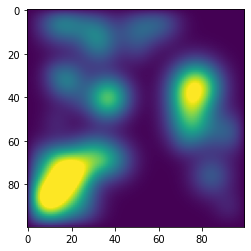

In [6]:
# create an environment to observe
env = PollutionModelEnvironment("water", 100, 100)
env.evolve_speed = 1
env.p_pollution = 0.1
for t in range(120):
    env.proceed()
plt.imshow(env.value, vmin=0, vmax=1.0)

In [10]:
# create an observation model
#im = ScalarFieldInformationModel_stored_observation("sample", env.width, env.height, \
#                                                    estimation_type="disk-fixed", 
#                                                    estimation_radius=10)
im = ScalarFieldInformationModel_stored_observation("sample", env.width, env.height, \
                                                    estimation_type="gaussian-process"
                                                    )
# generate a series random observations
for i in range(20):
    x = random.randint(0, env.width-1)
    y = random.randint(0, env.height-1)
    value = env.value[x,y]
    obs = {"x": x, "y": y, "value": value}
    im.add_observation(obs)
im.proceed(1)

C:\Users\lboloni\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 100. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


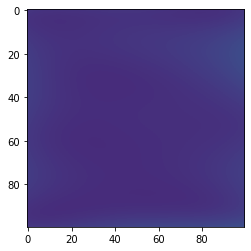

In [12]:
#plt.imshow(im.value, vmin=0, vmax=1.0)
plt.imshow(im.uncertainty, vmin=0, vmax=1.0)

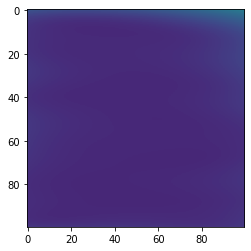

In [7]:
plt.imshow(im.uncertainty, vmin=0, vmax=1.0)

In [10]:
kernel = RationalQuadratic(length_scale = [2.0, 2.0], length_scale_bounds = [1, 100], \
                           alpha=0.1) +\
    WhiteKernel(noise_level=0.2)
#kernel = RationalQuadratic(length_scale = [2.0, 2.0], length_scale_bounds = [1, 100], alpha=1000) +\
#    WhiteKernel(noise_level=0.2)

#kernel = RBF(length_scale = [2.0, 2.0], length_scale_bounds = [1, 100]) +\
#    WhiteKernel(noise_level=0.5)

im2 = ScalarFieldInformationModel_stored_observation("sample", env.width, env.height, \
                                                    estimation_type="gaussian-process",
                                                     gp_kernel = kernel
                                                    )

In [11]:
im2.observations.extend(im.observations)
im2.proceed(1.0)
plt.imshow(im2.value, vmin=0, vmax=1.0)

ValueError: length of x0 != length of bounds